In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import networkx as nx
import re
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf
import itertools

In [2]:
flow_data = pd.read_csv("london_flows.csv")

flow_data = flow_data[flow_data['station_origin'] != 'Battersea Park']
flow_data = flow_data[flow_data['station_destination'] != 'Battersea Park']
flow_data = flow_data[flow_data['station_origin'] != flow_data['station_destination']]

print(f"There are {len(flow_data['station_origin'].unique())} unique origins.")
print(f"There are {len(flow_data['station_destination'].unique())} unique destinations.")

There are 398 unique origins.
There are 398 unique destinations.


In [3]:
flowmat = pd.pivot_table(flow_data, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowmat

C:\Users\75482\AppData\Local\Temp\ipykernel_15896\564040815.py:1: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flowmat = pd.pivot_table(flow_data, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\564040815.py:1: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flowmat = pd.pivot_table(flow_data, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\564040815.py:1: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is current

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


## Production-constrained Model 

In [4]:
# log the data
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    flow_data[f"log_{x}"] = np.log(flow_data[x])
    log_x_vars.append(f"log_{x}")

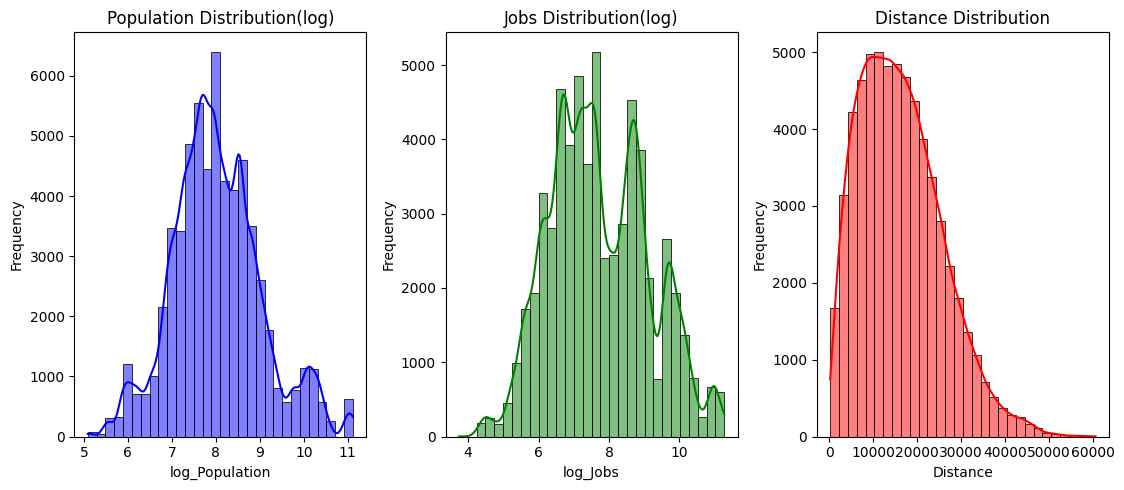

In [5]:
plt.figure(figsize=(15, 5))

# Plot for population
plt.subplot(1, 4, 1)
sns.histplot(flow_data['log_population'], kde=True, bins=30, color='blue')
plt.title('Population Distribution(log)')
plt.xlabel('log_Population')
plt.ylabel('Frequency')

# Plot for jobs
plt.subplot(1, 4, 2)
sns.histplot(flow_data['log_jobs'], kde=True, bins=30, color='green')
plt.title('Jobs Distribution(log)')
plt.xlabel('log_Jobs')
plt.ylabel('Frequency')

# Plot for distance
plt.subplot(1, 4, 3)
sns.histplot(flow_data['distance'], kde=True, bins=30, color='red')
plt.title('Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [6]:
df = flow_data.copy()
formula1 = 'flows ~ station_origin + log_jobs + distance - 1'
prodPoisson = smf.glm(formula = formula1, data=df, family=sm.families.Poisson()).fit()
prodPoisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Tue, 03 Sep 2024   Deviance:                   1.6477e+06
Time:                        09:59:05   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
station_origin[Abbey Road]                     -2.9143      0.041    -70.509      0.000      -2.995      -2.833
station_origin[Acton Central]                  -1.1621      0.029    -39.960      0.000      -1.219      -1.105
station_origin[Acton Town]                     -1.6131      0.017    -92.801      0.000      -1.647      -1.579
station_origin[Aldgate]                        -2.9430      0.020   -150.138      0.000      -2.981      -2.905
station_origin[Aldgate East]                   -2.8548      0.019   -151.960      0.000      -2.892      -2.818
station_origin[All Saints]                     -2.8783      0.037    -77.219      0.000      -2.951      -2.805
station_origin[Alperton]                       -1.6542      0.026    -64.731      0.000      -1.704      -1.604
station_origin[Amersham]                        1.0008      0.030     33.747      0.000       0.943       1.059
station_origin[Anerley]                        -1.0369      0.040    -26.044      0.000      -1.115      -0.959
station_origin[Angel]                          -2.5875      0.017   -156.011      0.000      -2.620      -2.555
station_origin[Archway]                        -1.7164      0.015   -117.258      0.000      -1.745      -1.688
station_origin[Arnos Grove]                    -1.4184      0.019    -73.907      0.000      -1.456      -1.381
station_origin[Arsenal]                        -2.8836      0.022   -128.905      0.000      -2.927      -2.840
station_origin[Baker Street]                   -2.0100      0.013   -154.107      0.000      -2.036      -1.984
station_origin[Balham]                         -0.8774      0.012    -73.687      0.000      -0.901      -0.854
station_origin[Bank and Monument]              -0.7522      0.008    -90.130      0.000      -0.769      -0.736
station_origin[Barbican]                       -3.8356      0.029   -131.979      0.000      -3.893      -3.779
station_origin[Barking]                        -0.5144      0.013    -40.520      0.000      -0.539      -0.490
station_origin[Barkingside]                    -1.4598      0.028    -51.227      0.000      -1.516      -1.404
station_origin[Barons Court]                   -2.1412      0.017   -127.494      0.000      -2.174      -2.108
station_origin[Bayswater]                      -3.2347      0.026   -124.738      0.000      -3.286      -3.184
station_origin[Beckton]                        -1.5104      0.030    -50.777      0.000      -1.569      -1.452
station_origin[Beckton Park]                   -3.1889      0.059    -54.287      0.000      -3.304      -3.074
station_origin[Becontree]                      -1.2801      0.022    -59.004      0.000      -1.323      -1.238
station_origin[Belsize Park]                   -2.5574     

In [7]:
O_i = pd.DataFrame(df.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df = df.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(df.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df = df.merge(D_j, on = "station_destination", how = "left" )

C:\Users\75482\AppData\Local\Temp\ipykernel_15896\3918045554.py:1: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  O_i = pd.DataFrame(df.groupby(["station_origin"])["flows"].agg(np.sum))
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\3918045554.py:5: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(df.groupby(["station_destination"])["flows"].agg(np.sum))


In [8]:
coefs = pd.DataFrame(prodPoisson.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)

df = df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df.drop(columns = ["coef"], inplace = True)

In [9]:
alpha_i = prodPoisson.params[0:398]
gamma = prodPoisson.params[398]
beta = -prodPoisson.params[399]

C:\Users\75482\AppData\Local\Temp\ipykernel_15896\126232816.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodPoisson.params[398]
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\126232816.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodPoisson.params[399]


In [10]:
df["prodsimest1"] = np.exp(df["alpha_i"]+gamma*df["log_jobs"] - beta*df["distance"])
df["prodsimest1"] = round(df["prodsimest1"],0)

In [11]:
def CalcRSquared(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2

def CalcRMSE(observed, estimated):
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [12]:
R_1 = CalcRSquared(df["flows"],df["prodsimest1"])
RMSE1 = CalcRMSE(df["flows"], df["prodsimest1"])
print("R square is:", R_1)
print("RMSE is: ", RMSE1)
print("My beta: ", beta)
print("My gamma: ", gamma )
print("DF :", df.columns)

R square is: 0.46806484435428586
RMSE is:  96.263
My beta:  0.00015316619346410616
My gamma:  0.7552215895688075
DF : Index(['station_origin', 'station_destination', 'flows', 'population', 'jobs',
       'distance', 'log_population', 'log_jobs', 'log_distance', 'O_i', 'D_j',
       'alpha_i', 'prodsimest1'],
      dtype='object')


# Scenarios

In [13]:
# Scenario A
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val
df["scenarioA_jobs"] = df.apply(new_jobs, axis=1)
df.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,scenarioA_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,78.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,-2.914322,4.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,599,845,-2.914322,5.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,-2.914322,4.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,-2.914322,3.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,-2.914322,4.0,611.0


In [14]:
gamma_A = df["scenarioA_jobs"]**gamma
beta_A = np.exp(df["distance"]*(-beta))
df["Ai1"] = gamma_A * beta_A
A_i = pd.DataFrame(df.groupby(["station_origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
df = df.merge(A_i, left_on="station_origin", right_index=True, how="left")

df["prodsimest2"] = df["A_i"]*df["O_i"]*gamma_A*beta_A
df["prodsimest2"] = round(df["prodsimest2"])


C:\Users\75482\AppData\Local\Temp\ipykernel_15896\3991820770.py:4: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(df.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [15]:
df['prodsimest1'] = df['prodsimest1'].replace(0, 1)

df["flow_changeA"] = df["prodsimest2"] - df["prodsimest1"]
df["flow_change_percentageA"]=((df['prodsimest2'] - df['prodsimest1']) / df['prodsimest1']) * 100
total_flow = df["flows"].sum()
scenarioA_flow = df["prodsimest2"].sum()
flow_change = total_flow - scenarioA_flow
percen = 100*(flow_change/total_flow)

print("Scenario A total flow: ", scenarioA_flow)
print("Flow changed from origin to scenario A: ", flow_change)
print(f"{percen}%"+" flow changed")
print("Average percentage of flow change:", df["flow_change_percentageA"].mean())

Scenario A total flow:  1541397.0
Flow changed from origin to scenario A:  886.0
0.057447303769801% flow changed
Average percentage of flow change: -13.840926725792787


In [16]:
print(f'R-squared: {CalcRSquared(df["flows"], df["prodsimest2"])}')
print(f'RMSE: {CalcRMSE(df["flows"], df["prodsimest2"])}')

R-squared: 0.45165207589823186
RMSE: 97.69


In [17]:
df.head(10)


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,scenarioA_jobs,Ai1,A_i,prodsimest2,flow_changeA,flow_change_percentageA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,78.0,78549.0,1432.231104,0.000097,83.0,5.0,6.410256
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.0,442.0,27.026714,0.000097,2.0,1.0,100.000000
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.0,665.0,75.982904,0.000097,4.0,0.0,0.000000
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.0,29386.0,1086.638601,0.000097,63.0,-36.0,-36.363636
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.0,15428.0,1034.750388,0.000097,60.0,4.0,7.142857
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,-2.914322,4.0,1208.0,76.359709,0.000097,4.0,0.0,0.000000
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,599,845,-2.914322,5.0,845.0,90.364722,0.000097,5.0,0.0,0.000000
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,-2.914322,4.0,1748.0,76.412509,0.000097,4.0,0.0,0.000000
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,-2.914322,3.0,850.0,59.958418,0.000097,3.0,0.0,0.000000
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,-2.914322,4.0,611.0,69.306471,0.000097,4.0,0.0,0.000000


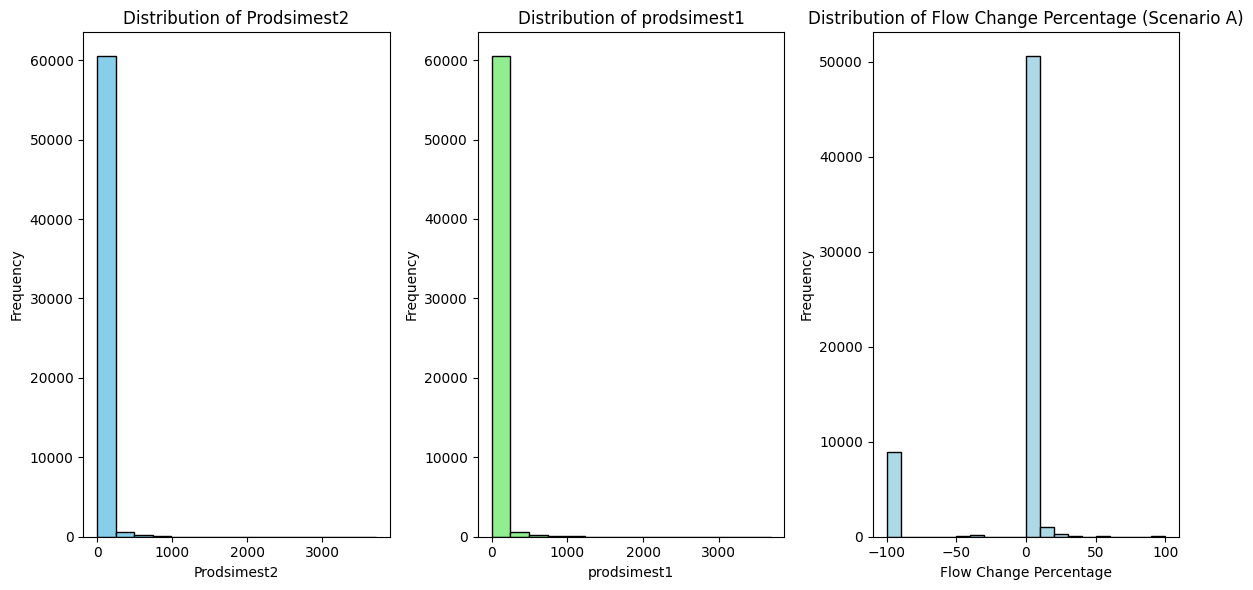

In [18]:
plt.figure(figsize=(12, 6))

# Plotting the distribution of 'prodsimest2'
plt.subplot(1, 3, 1)
plt.hist(df['prodsimest2'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Prodsimest2')
plt.xlabel('Prodsimest2')
plt.ylabel('Frequency')


# Plotting the distribution of 'flows'
plt.subplot(1, 3, 2)
plt.hist(df['prodsimest1'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of prodsimest1')
plt.xlabel('prodsimest1')
plt.ylabel('Frequency')

# Plotting the distribution of flow change percentages
plt.subplot(1, 3, 3)
plt.hist(df['flow_change_percentageA'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution of Flow Change Percentage (Scenario A)')
plt.xlabel('Flow Change Percentage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scenario B1&B2

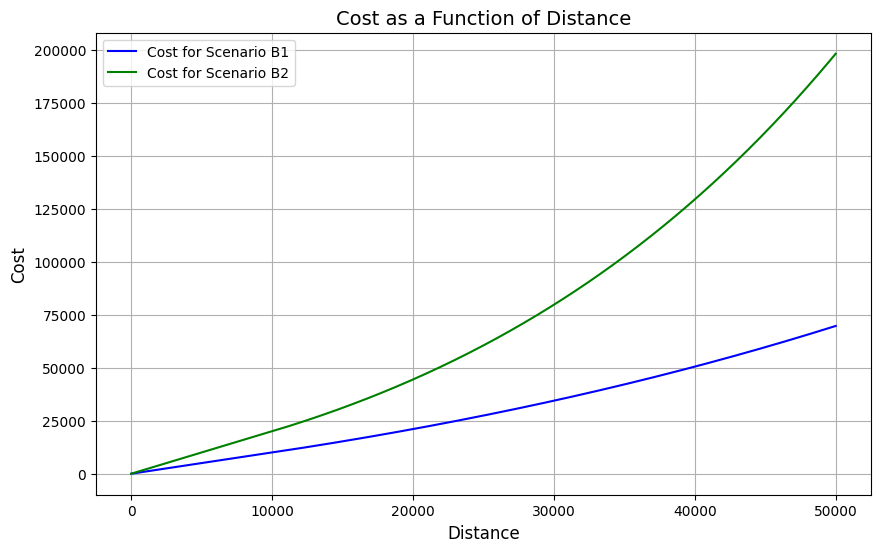

C:\Users\75482\AppData\Local\Temp\ipykernel_15896\1707397794.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B['cost_B1'] = cost(df_B['distance'], 10000, 1, 1.00001)
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\1707397794.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B['cost_B2'] = cost(df_B['distance'], 10000, 2, 1.00002)


In [19]:
df_B = df[['station_origin','station_destination','flows','population','jobs','distance','O_i','D_j','prodsimest1','prodsimest2' ,'flow_changeA','flow_change_percentageA']]

import numpy as np
import matplotlib.pyplot as plt

def cost(distance, threshold, increase1, exp_base):
    cost = distance * increase1  
    
    threshold_mask = distance > threshold
    cost[threshold_mask] = (
        (threshold * increase1) +  
        (distance[threshold_mask] - threshold) * increase1 * exp_base ** (distance[threshold_mask] - threshold)  
    )
    return cost
distance = np.linspace(0, 50000, 1000)
cost_B1 = cost(distance, 10000, 1, 1.00001)
cost_B2 = cost(distance, 10000, 2, 1.00002)

plt.figure(figsize=(10, 6))
plt.plot(distance, cost_B1, label='Cost for Scenario B1', color='blue')
plt.plot(distance, cost_B2, label='Cost for Scenario B2', color='green')

plt.xlabel('Distance', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Cost as a Function of Distance', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

df_B['cost_B1'] = cost(df_B['distance'], 10000, 1, 1.00001)
df_B['cost_B2'] = cost(df_B['distance'], 10000, 2, 1.00002)


In [20]:
# recalibrate
# B1
gamma_B = df_B["jobs"]**gamma
beta_B1 = np.exp(df_B["cost_B1"]*(-beta))
df_B["Ai1_B1"] = gamma_B*beta_B1
A_iB1 = pd.DataFrame(df_B.groupby(["station_origin"])["Ai1_B1"].agg(np.sum))
A_iB1["Ai1_B1"] = 1/A_iB1["Ai1_B1"]
A_iB1.rename(columns={"Ai1_B1":"A_iB1"}, inplace=True)
df_B= df_B.merge(A_iB1, left_on="station_origin", right_index=True, how="left")
df_B["prodsimestB1"] = df_B["A_iB1"]*df_B["O_i"]*gamma_B*beta_B1
df_B["prodsimestB1"] = round(df_B["prodsimestB1"])

df_B["flow_changeB1"] = df_B["prodsimestB1"] - df_B["prodsimest1"]
df_B["flow_change_percentageB1"]=((df_B['prodsimestB1'] - df_B['prodsimest1']) / df['prodsimest1']) * 100
total_flow = df_B["flows"].sum()
scenarioB1_flow = df_B["prodsimestB1"].sum()
flow_changeB1 = total_flow - scenarioB1_flow
percenB1 = 100*(flow_changeB1/total_flow)
print("Scenario B1 total flow: ", scenarioB1_flow)
print("Flow changed from origin to scenario B1: ", flow_changeB1)
print(f"{percenB1}%"+" flow changed")


# B2
gamma_B = df_B["jobs"]**gamma
beta_B2 = np.exp(df_B["cost_B2"]*(-beta))
df_B["Ai1_B2"] = gamma_B*beta_B2
A_iB2 = pd.DataFrame(df_B.groupby(["station_origin"])["Ai1_B2"].agg(np.sum))
A_iB2["Ai1_B2"] = 1/A_iB2["Ai1_B2"]
A_iB2.rename(columns={"Ai1_B2":"A_iB2"}, inplace=True)
df_B= df_B.merge(A_iB2, left_on="station_origin", right_index=True, how="left")
df_B["prodsimestB2"] = df_B["A_iB2"]*df_B["O_i"]*gamma_B*beta_B2
df_B["prodsimestB2"] = round(df_B["prodsimestB2"])

df_B["flow_changeB2"] = df_B["prodsimestB2"] - df_B["prodsimest1"]
df_B["flow_change_percentageB2"]=((df_B['prodsimestB2'] - df_B['prodsimest1']) / df['prodsimest1']) * 100
total_flow = df_B["flows"].sum()
scenarioB2_flow = df_B["prodsimestB2"].sum()
flow_changeB2 = total_flow - scenarioB2_flow
percenB2 = 100*(flow_changeB2/total_flow)
print("Scenario B2 total flow: ", scenarioB2_flow)
print("Flow changed from origin to scenario B2: ", flow_changeB2)
print(f"{percenB2}%"+" flow changed")

Scenario B1 total flow:  1541167.0
Flow changed from origin to scenario B1:  1116.0
0.07236026073035882% flow changed
Scenario B2 total flow:  1540913.0
Flow changed from origin to scenario B2:  1370.0
0.08882935233027921% flow changed


C:\Users\75482\AppData\Local\Temp\ipykernel_15896\4289464185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B["Ai1_B1"] = gamma_B*beta_B1
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\4289464185.py:6: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_iB1 = pd.DataFrame(df_B.groupby(["station_origin"])["Ai1_B1"].agg(np.sum))
C:\Users\75482\AppData\Local\Temp\ipykernel_15896\4289464185.py:28: FutureWarning: The provided callable <function sum at 0x000001E0FE307100> is currently using SeriesGroupBy.sum. In a future version of pandas, the provi

In [21]:

print("Scenario B1 total flow: ", scenarioB1_flow)
print("Flow changed from origin to scenario B1: ", flow_changeB1)
print(f"{percenB1}%"+" flow changed")
print("B1 Average percentage of flow change:", df_B["flow_change_percentageB1"].mean())
print(f'R-squared: {CalcRSquared(df_B["flows"], df_B["prodsimestB1"])}')
print(f'RMSE: {CalcRMSE(df_B["flows"], df_B["prodsimestB1"])}')

print("Scenario B2 total flow: ", scenarioB2_flow)
print("Flow changed from origin to scenario B2: ", flow_changeB2)
print(f"{percenB2}%"+" flow changed")
print("B2 Average percentage of flow change:", df_B["flow_change_percentageB2"].mean())
print(f'R-squared: {CalcRSquared(df_B["flows"], df_B["prodsimestB2"])}')
print(f'RMSE: {CalcRMSE(df_B["flows"], df_B["prodsimestB2"])}')

Scenario B1 total flow:  1541167.0
Flow changed from origin to scenario B1:  1116.0
0.07236026073035882% flow changed
B1 Average percentage of flow change: -20.62338151840333
R-squared: 0.4668761991040561
RMSE: 96.316
Scenario B2 total flow:  1540913.0
Flow changed from origin to scenario B2:  1370.0
0.08882935233027921% flow changed
B2 Average percentage of flow change: -51.18425464697233
R-squared: 0.3923800378338325
RMSE: 104.57


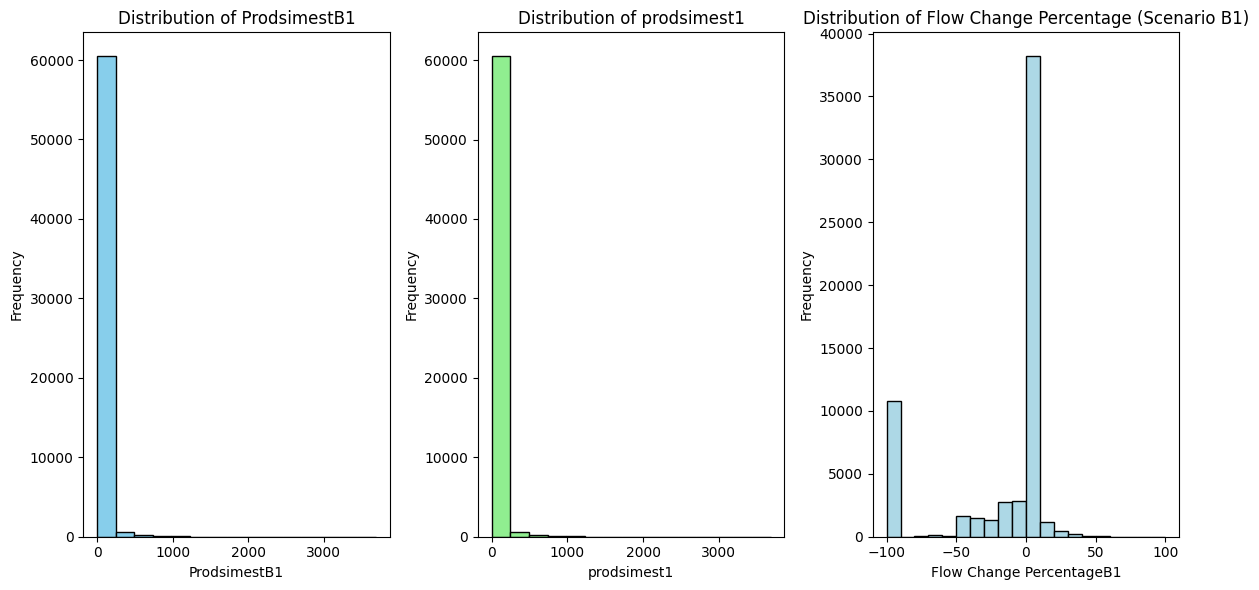

In [22]:
plt.figure(figsize=(12, 6))

# Plotting the distribution of 'prodsimestB1'
plt.subplot(1, 3, 1)
plt.hist(df_B['prodsimestB1'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of ProdsimestB1')
plt.xlabel('ProdsimestB1')
plt.ylabel('Frequency')


# Plotting the distribution of 'flows'
plt.subplot(1, 3, 2)
plt.hist(df_B['prodsimest1'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of prodsimest1')
plt.xlabel('prodsimest1')
plt.ylabel('Frequency')

# Plotting the distribution of flow change percentages
plt.subplot(1, 3, 3)
plt.hist(df_B['flow_change_percentageB1'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution of Flow Change Percentage (Scenario B1)')
plt.xlabel('Flow Change PercentageB1')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

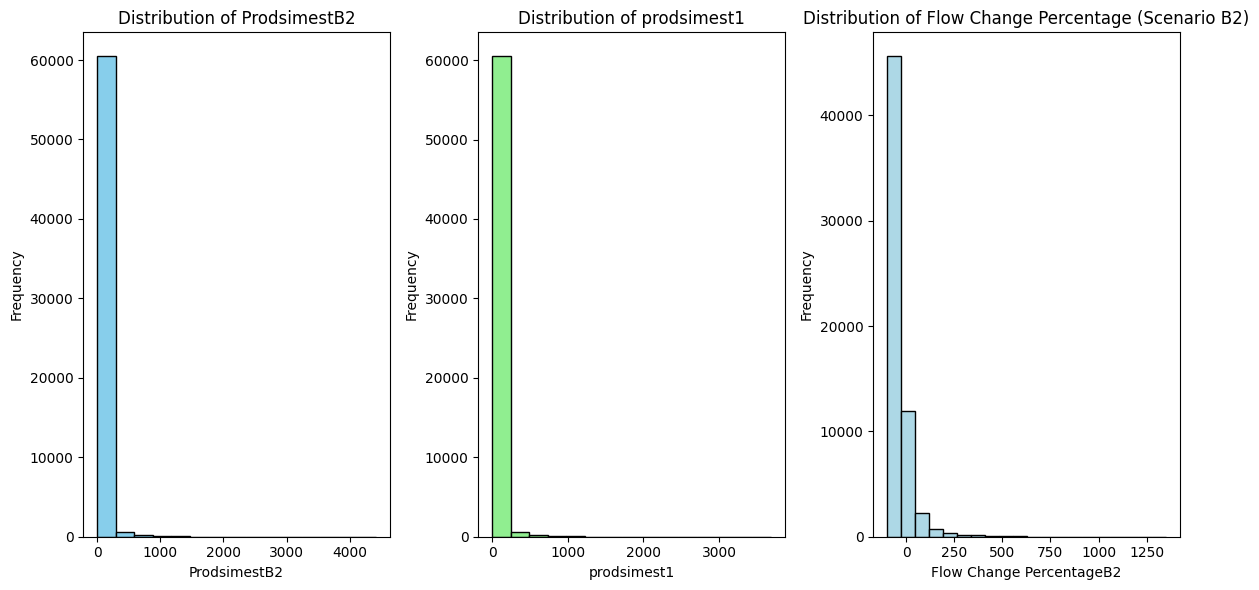

In [23]:
plt.figure(figsize=(12, 6))

# Plotting the distribution of 'prodsimestB2'
plt.subplot(1, 3, 1)
plt.hist(df_B['prodsimestB2'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of ProdsimestB2')
plt.xlabel('ProdsimestB2')
plt.ylabel('Frequency')


# Plotting the distribution of 'flows'
plt.subplot(1, 3, 2)
plt.hist(df_B['prodsimest1'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of prodsimest1')
plt.xlabel('prodsimest1')
plt.ylabel('Frequency')

# Plotting the distribution of flow change percentages
plt.subplot(1, 3, 3)
plt.hist(df_B['flow_change_percentageB2'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution of Flow Change Percentage (Scenario B2)')
plt.xlabel('Flow Change PercentageB2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()